In [119]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame

import warnings
warnings.filterwarnings('ignore')

In [120]:
df_sample = pd.read_csv('./train_filtered_sample.csv')
df_sample.head(3)

,uid,lat,lng,datetime,trip_id,call_type
0,20000003,41.143401,-8.602875,2013-09-22 01:25:17,1379823917620000003,A
1,20000003,41.142033,-8.601894,2013-09-22 01:25:32,1379823917620000003,A
2,20000003,41.139567,-8.601381,2013-09-22 01:25:47,1379823917620000003,A


In [121]:
pdf = PTRAILDataFrame(data_set=df_sample,
                        latitude='lat',
                        longitude='lng',
                        datetime='datetime',
                        traj_id='trip_id',
                        rest_of_columns=['uid', 'call_type'])
print(f"The dimensions of the dataframe:{pdf.shape}")
print(f"Type of the dataframe: {type(pdf)}")
pdf.head(3)

The dimensions of the dataframe:(40154, 4)
Type of the dataframe: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>


uid  ...  call_type
traj_id             DateTime                       ...           
1372668941620000435 2013-07-01 05:55:41  20000435  ...          A
                    2013-07-01 05:55:56  20000435  ...          A
                    2013-07-01 05:56:11  20000435  ...          A

[3 rows x 4 columns]

**Caracteírsticas Temporais**

In [122]:
from ptrail.features.temporal_features import TemporalFeatures as temporal

In [123]:
temporal_features_df = temporal.create_date_column(pdf)
temporal_features_df = temporal.create_day_of_week_column(temporal_features_df)
temporal_features_df = temporal.create_time_of_day_column(temporal_features_df)
temporal_features_df = temporal.create_time_column(temporal_features_df)
temporal_features_df.head(3)

uid  ...      Time
traj_id             DateTime                       ...          
1372668941620000435 2013-07-01 05:55:41  20000435  ...  05:55:41
                    2013-07-01 05:55:56  20000435  ...  05:55:56
                    2013-07-01 05:56:11  20000435  ...  05:56:11

[3 rows x 8 columns]

**Características Derivadas do Movimento (Kinematic features)**

In [124]:
from ptrail.features.kinematic_features import KinematicFeatures as kinematic

In [125]:
kinematic_features_df = kinematic.create_distance_column(temporal_features_df)
kinematic_features_df = kinematic.create_jerk_column(kinematic_features_df)
kinematic_features_df = kinematic.create_rate_of_br_column(kinematic_features_df)
kinematic_features_df.head(3)

uid  ...  Rate_of_bearing_rate
traj_id             DateTime                       ...                      
1372668941620000435 2013-07-01 05:55:41  20000435  ...                   NaN
                    2013-07-01 05:55:56  20000435  ...                   NaN
                    2013-07-01 05:56:11  20000435  ...          1.971929e-07

[3 rows x 15 columns]

**Extrai outliers**

In [126]:
from ptrail.preprocessing.filters import Filters as filt

In [127]:
outlier_df = filt.hampel_outlier_detection(kinematic_features_df, column_name='Acceleration')
print(f"Length of original: {len(outlier_df)}")
print(f"Length after outlier removal: {len(outlier_df)}")
print(f"Number of points removed: {len(kinematic_features_df) - len(outlier_df)}")

Length of original: 38230
Length after outlier removal: 38230
Number of points removed: 1924


**Filtra ponto por distancia máxima**

In [128]:
filter_df_distance = filt.filter_by_max_consecutive_distance(outlier_df, max_distance=4500)
print(f"Length of original: {len(outlier_df)}")
print(f"Length of Max distance Filtered DF: {len(filter_df_distance)}")
print(f"Number of points removed: {len(outlier_df) - len(filter_df_distance)}")

Length of original: 38230
Length of Max distance Filtered DF: 37397
Number of points removed: 833


**Classificação de 'call_type'**

In [129]:
from ptrail.preprocessing.statistics import Statistics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [130]:
def plot_f1_weighted(ptrail_dataframe: any, ax: any, title='Accuracy x Model'):
    target_col_name = 'call_type'
    stats_df = Statistics.generate_kinematic_stats(dataframe=ptrail_dataframe,
                                                target_col_name=target_col_name)
    pivoted = Statistics.pivot_stats_df(dataframe=stats_df,
                                        target_col_name=target_col_name)
    names = ["Random Forest", "Decision Tree", "Gaussian Naive Bayes", "K-Nearest Neighbors"]
    models = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()]

    if not ax:
        _ = plt.figure(figsize=(9, 5))
        ax = plt.subplot(111)
        ax.set_facecolor('gainsboro')

    skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
    for i, name, model in zip(range(0, 5), names, models):
        scores = cross_val_score(model, pivoted.drop(columns=[target_col_name]), pivoted[target_col_name],
                                scoring='accuracy', cv=skf, n_jobs=-1)
        ax.boxplot(x=scores, positions=[i], vert=True,
                widths=0.60, patch_artist=True)

    ax.title.set_text(title)
    ax.set_xticklabels(labels=names)
    ax.set_ylabel("Acurácia")
    ax.set_xlabel("Model")
    plt.tight_layout()

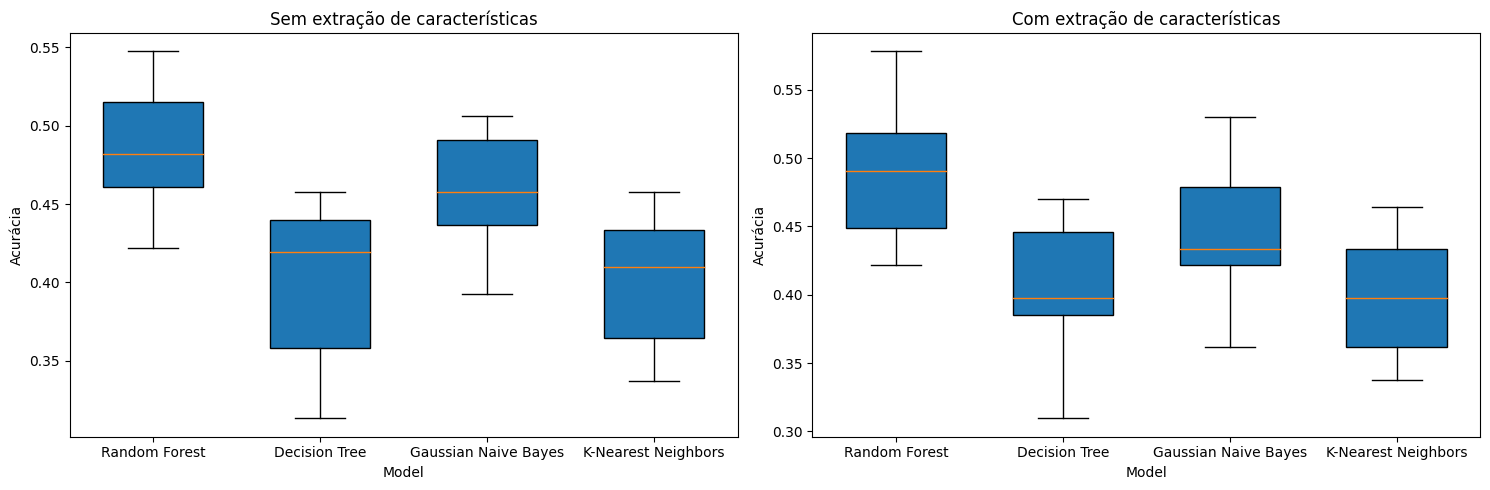

In [131]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_f1_weighted(pdf, ax=ax[0], title='Sem extração de características')
plot_f1_weighted(outlier_df, ax=ax[1], title='Com extração de características')
plt.show()